#### Importing Dependencies

##### Handling numpy version error

In [ ]:
!pip uninstall -y numpy

In [ ]:
!pip install numpy

In [ ]:
!pip install arviz

In [2]:
%matplotlib inline
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20,
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [3]:
from sklearn.model_selection import train_test_split

In [21]:
from sklearn.metrics import confusion_matrix

In [4]:
import pmlearn
from pmlearn.naive_bayes import GaussianNB
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc3


#### Ingest the Data

In [8]:
inputData = pd.read_csv('trainData_set1.csv')

##### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [9]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [10]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [11]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [12]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

In [13]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [14]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [15]:
X = np.array(X).reshape(-1,1)

In [16]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [17]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)

In [18]:
y.shape

(52396,)

#### Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Instantiate a model

In [16]:
model = GaussianNB()

#### Perform inference

In [17]:
model.fit(X_train, y_train, minibatch_size=20, inference_args={'n': 60})

Average Loss = inf: 100%|██████████| 60/60 [00:00<00:00, 1718.55it/s]
Finished [100%]: Average Loss = 140.6


GaussianNB()

#### Diagnose convergence

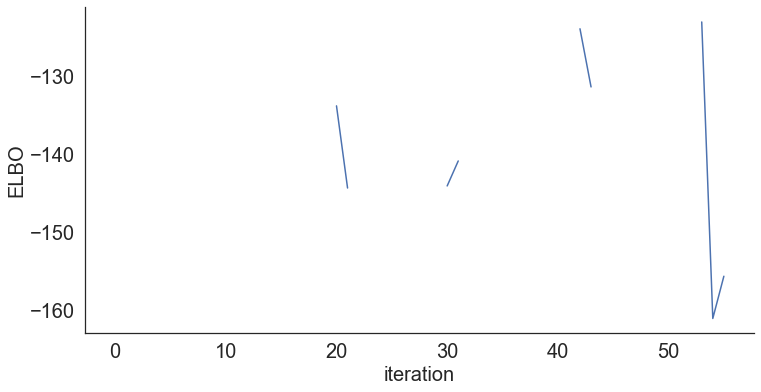

In [19]:
model.plot_elbo()

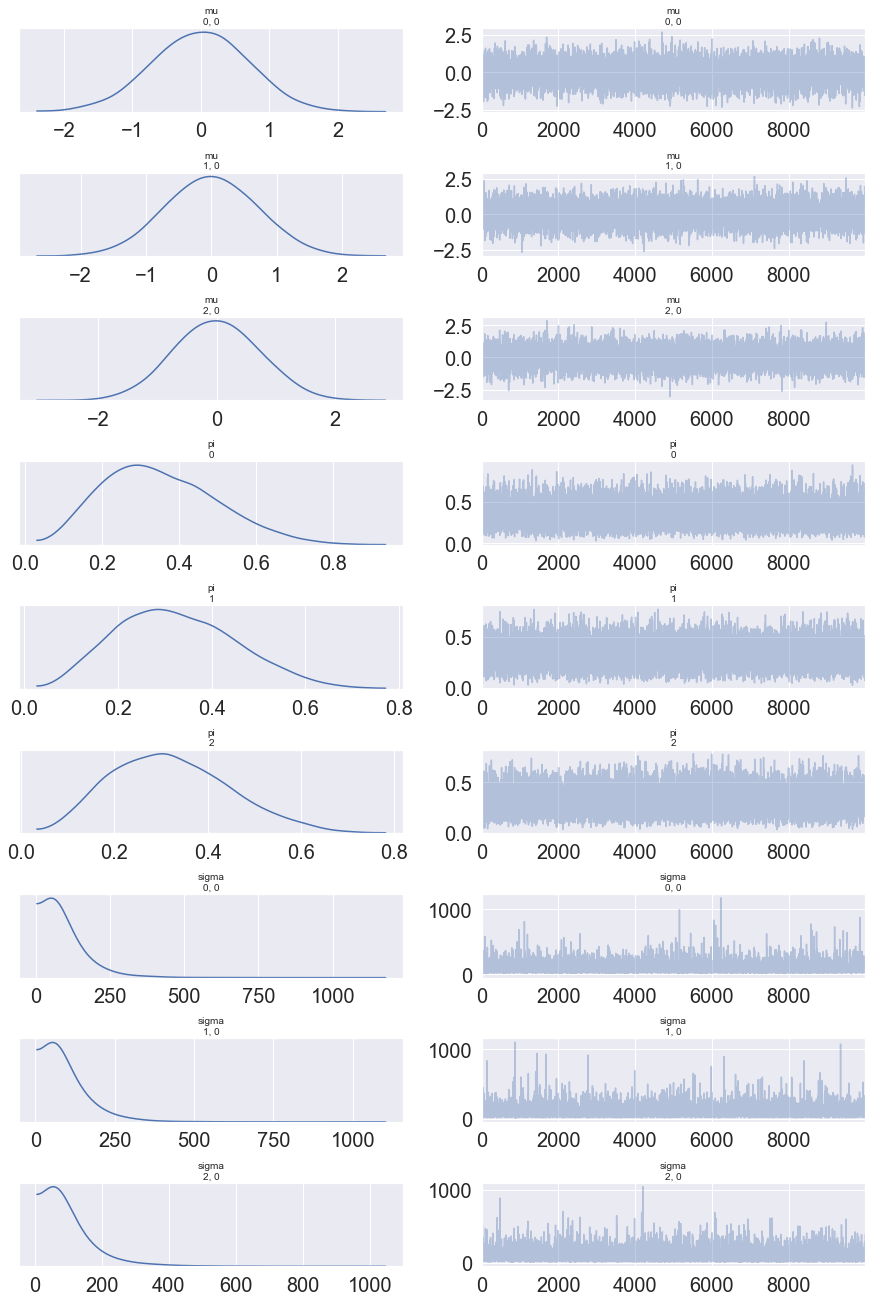

In [18]:
pm.traceplot(model.trace);

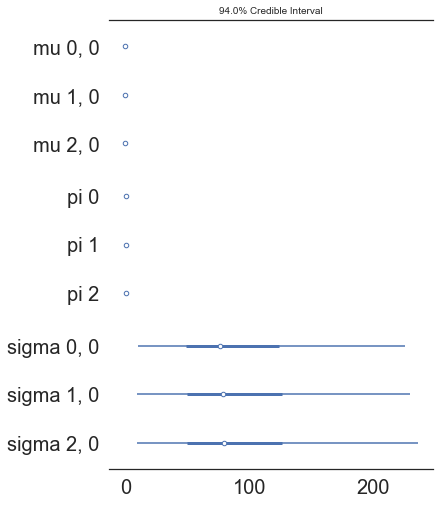

In [20]:
pm.forestplot(model.trace);

#### Critize the model

In [21]:
pm.summary(model.trace)

mean         sd  mc_error   hpd_2.5    hpd_97.5
mu__0_0      -0.008278   0.698676  0.006645 -1.354108    1.402272
mu__1_0       0.005191   0.702200  0.006779 -1.404153    1.341444
mu__2_0       0.004520   0.716077  0.007627 -1.360224    1.425047
pi__0         0.351196   0.145298  0.001378  0.095420    0.636193
pi__1         0.326257   0.127992  0.001291  0.086578    0.565015
pi__2         0.322547   0.126362  0.001358  0.093404    0.567868
sigma__0_0   98.059946  76.264587  0.657965  9.111845  239.262358
sigma__1_0  100.000452  78.617817  0.792814  9.791460  244.618274
sigma__2_0  100.953099  78.191128  0.860841  9.593390  253.423019

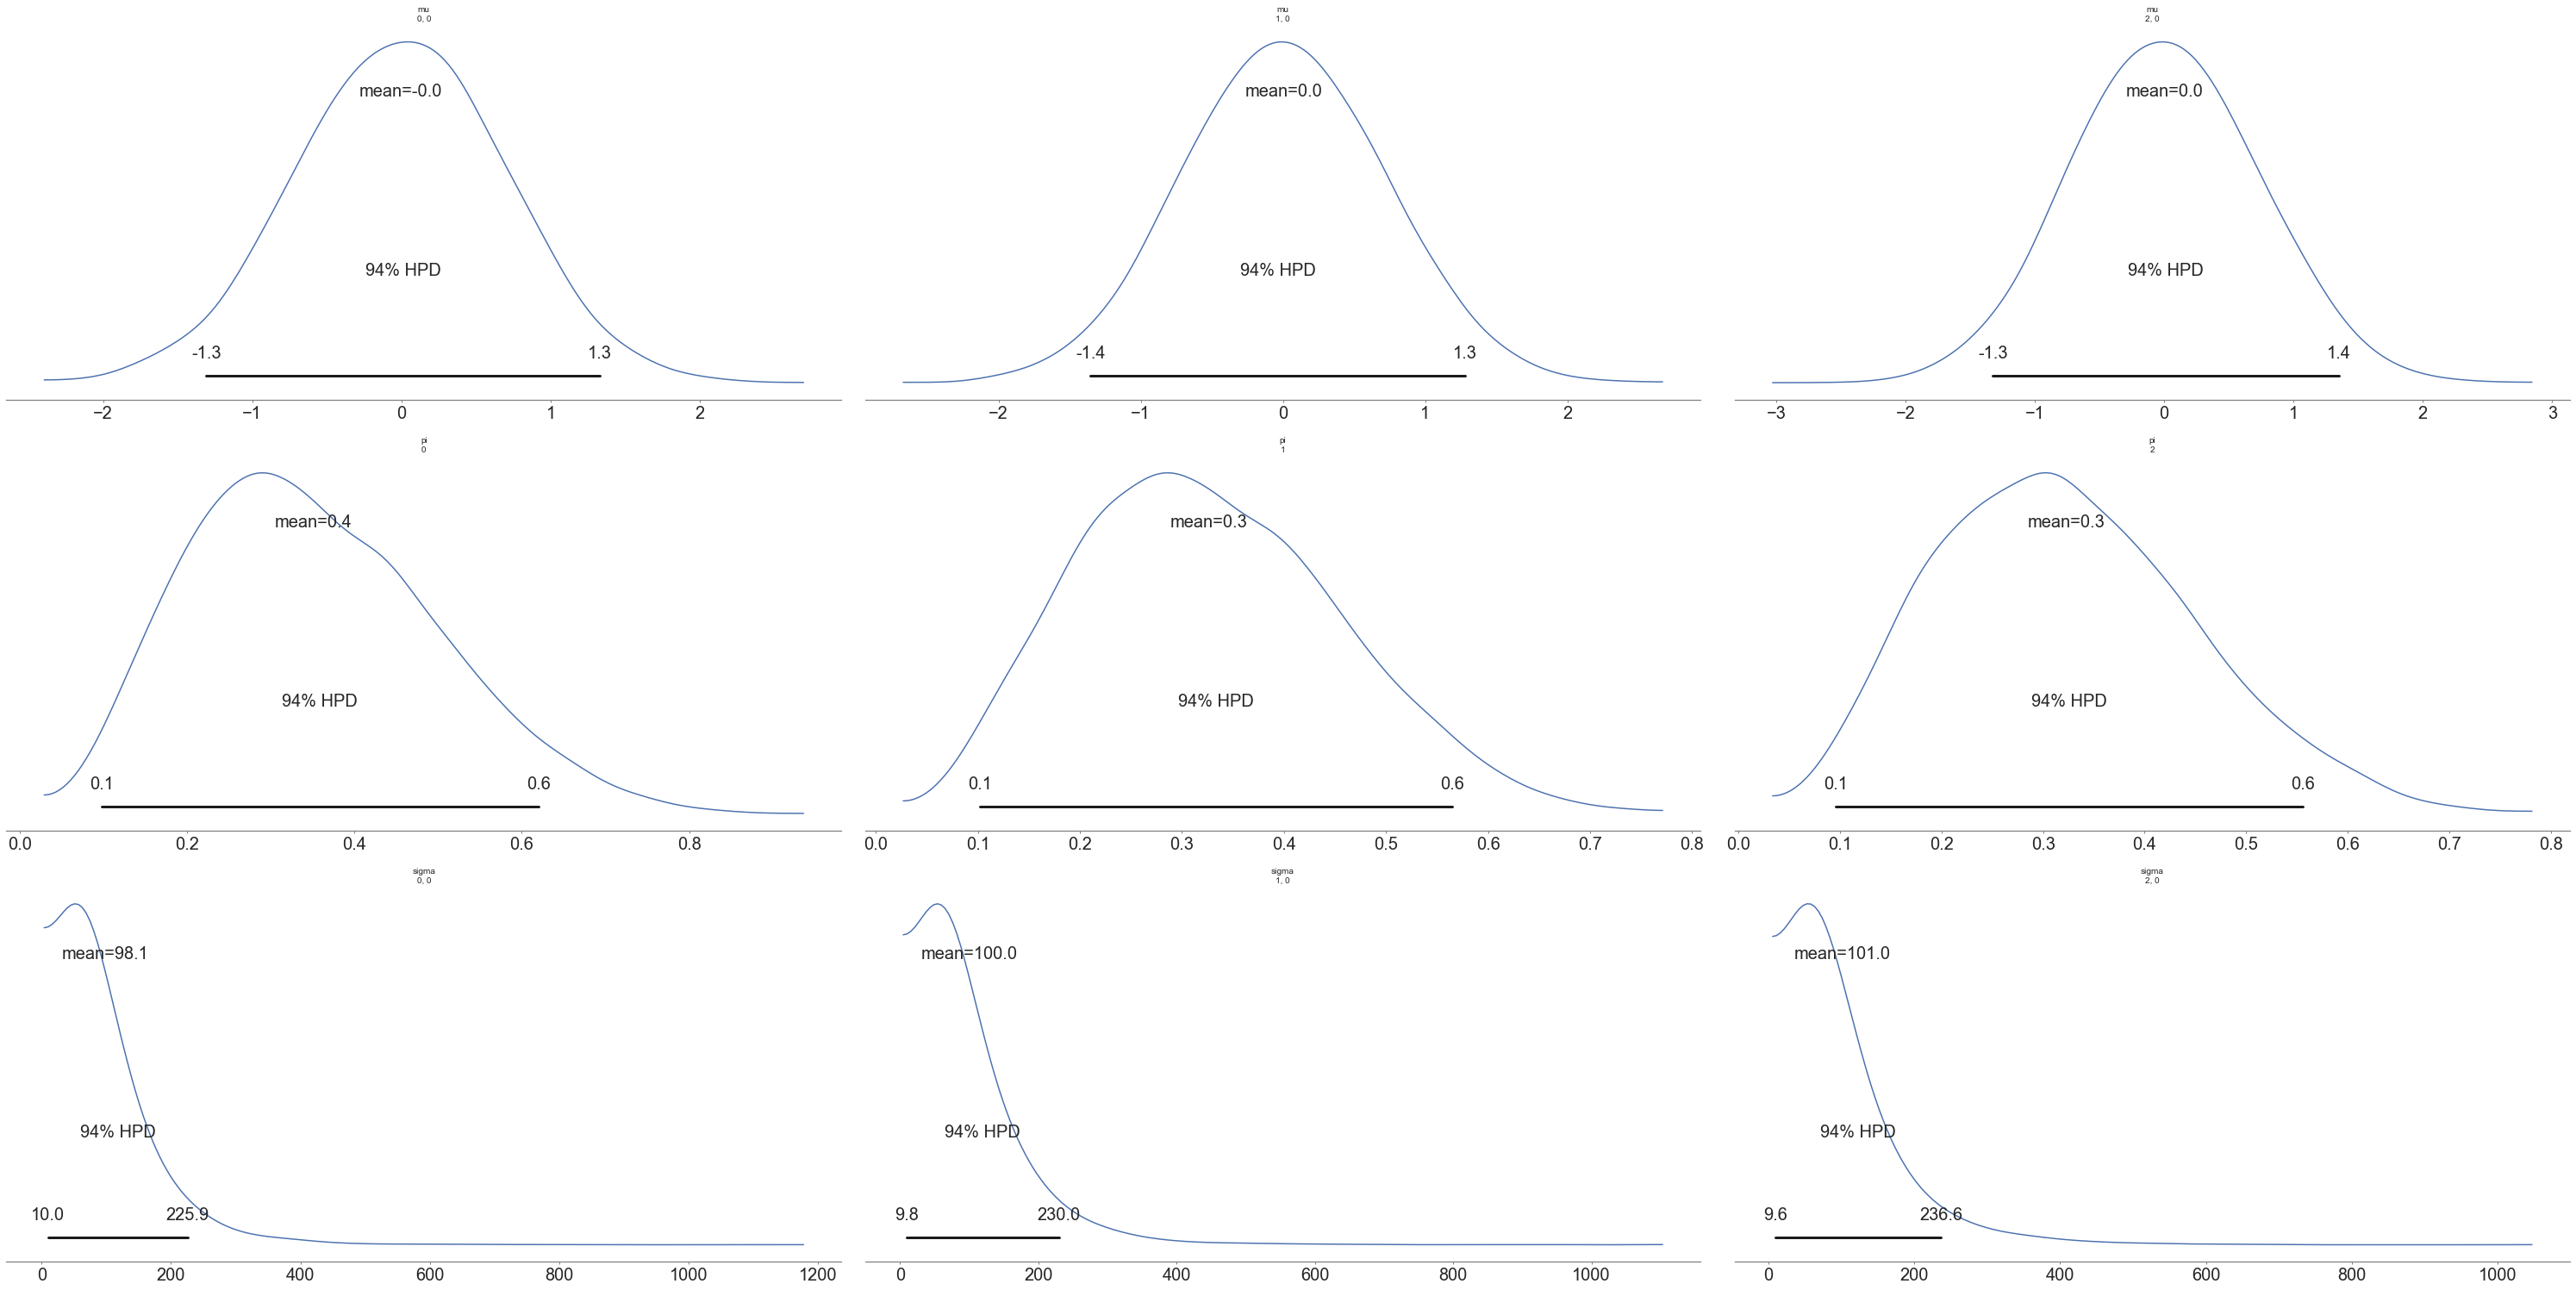

In [22]:
pm.plot_posterior(model.trace);

#### Use the model for prediction

In [23]:
y_probs = model.predict_proba(X_test)

In [24]:
y_predicted = model.predict(X_test)

In [25]:
model.score(X_test, y_test)

0.8980916030534352

In [27]:
model.save('pickle_jar/gaussian_nb')

#### Use aleady trained prediciton model

In [5]:
model_new = GaussianNB()

In [6]:
model_new.load('pickle_jar/gaussian_nb')

In [20]:
model_new.score(X_test, y_test)

0.8980916030534352

#### Infer prediction and probability score

In [22]:
y_pred = model_new.predict(X_test)

In [24]:
y_score = model_new.predict_proba(X_test)

In [25]:
y_score[:5]

array([[0.33566896, 0.33246258, 0.33186846],
       [0.33564692, 0.33247383, 0.33187925],
       [0.33567028, 0.33246208, 0.33186765],
       [0.33564427, 0.33247532, 0.33188041],
       [0.33566176, 0.33246588, 0.33187235]])

In [44]:
y_pred[:5]

array([0, 0, 0, 0, 0])

In [46]:
localPredict = []

for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):
    
    if (i > j) and (i > k):
        predict = -1
        localPredict.append(predict)
    
    elif (k > j) and (k > i):
        predict = 1
        localPredict.append(predict)
        
    else:
        predict = 0
        localPredict.append(predict)

In [49]:
localPredict[:5]

[-1, -1, -1, -1, -1]

#### Confusion Matrix

In [47]:
confusion_matrix(y_test, y_pred)

array([[   0,  281,    0],
       [   0, 4706,    0],
       [   0,  253,    0]])

In [48]:
confusion_matrix(y_test, localPredict)

array([[ 281,    0,    0],
       [4706,    0,    0],
       [ 253,    0,    0]])